In [63]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

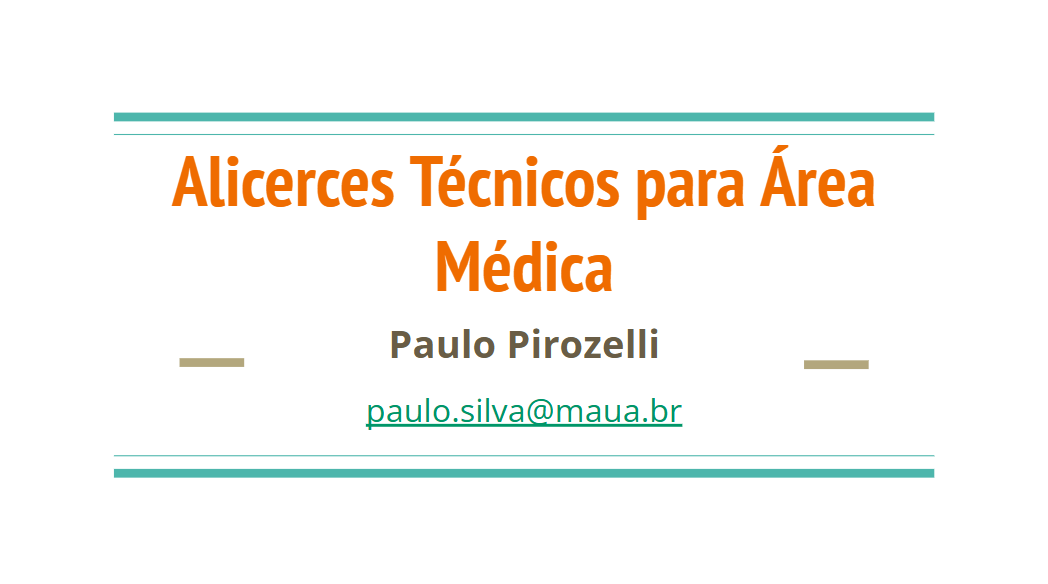

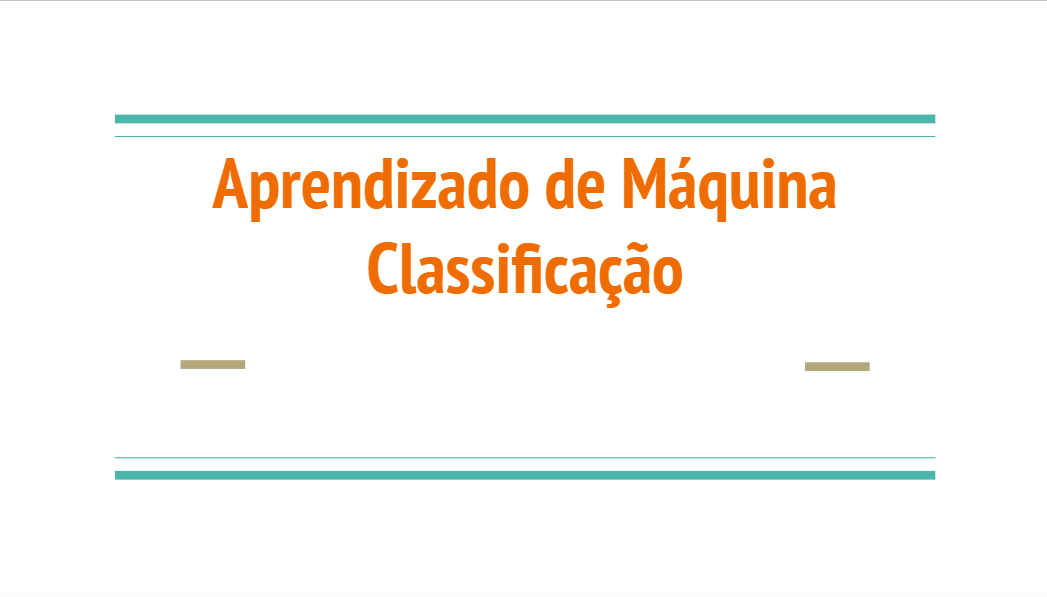

## Classifica√ß√£o

Nesta aula, apresentaremos mais dois modelos de classifica√ß√£o: **√Årvore de Decis√£o** e **Floresta Aleat√≥ria**.

Vamos partir de um exemplo motivador para nossa explica√ß√£o.

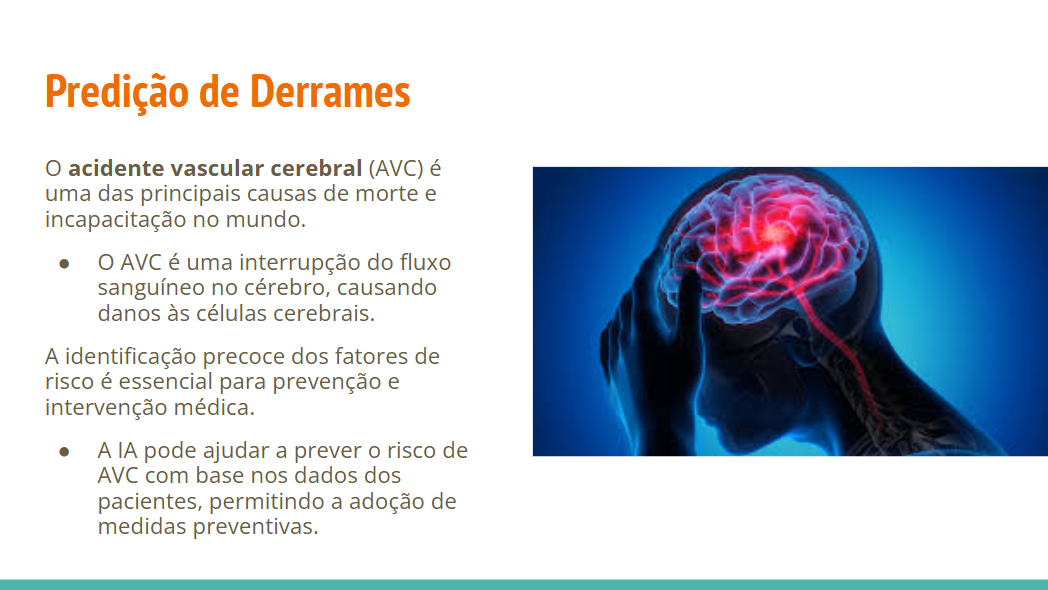

### Importa√ß√£o dos Dados

Para come√ßar, vamos tentar abrir o conjunto de dados. Os dados est√£o relacionados a campanhas de marketing direto (liga√ß√µes telef√¥nicas) de uma institui√ß√£o banc√°ria portuguesa.

As informa√ß√µes est√£o em um arquivo no formato .csv (Comma-Separated Values). Nesse tipo de arquivo, as colunas s√£o separadas por v√≠rgulas ou algum outro separados e cada linha corresponde a um registro.

In [64]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

print('Tamanho do dataset:', df.shape)

df.head()

Tamanho do dataset: (5110, 12)


id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

In [65]:
# Verificando as colunas presentes no dataset
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

As vari√°veis presentes no dataset s√£o as seguintes:

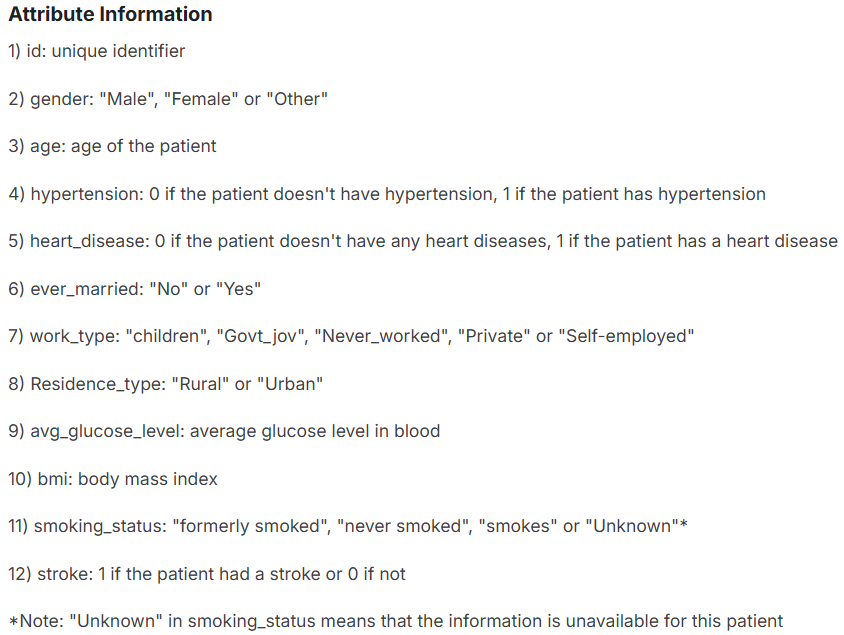

**Documenta√ß√£o completa:** https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset.

### Pr√©-processamento

#### 1. Integra√ß√£o de Bases de Dados

Nosso dataset j√° cont√©m todas as informa√ß√µes. N√£o foi preciso integrar diferentes bases.

#### 2. Limpeza dos Dados

##### Dados Faltantes

Dados faltantes podem ser um problema s√©rio para v√°rios tipos de modelos, impedindo que possam rodar. Vamos checar se h√° valores faltantes e se houver, vamos remov√™-los.



In [66]:
# Verificar valores faltantes
print(df.isnull().sum())

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


H√° 201 valores faltantes na coluna bmi. A solu√ß√£o que vou adotar √© imputar a m√©dia da vari√°vel, que √© um valor neutro.

In [67]:
# Calcula a m√©dia (ignorando os NaNs)
media_bmi = df['bmi'].mean()

# Imputa os valores faltantes com a m√©dia
df['bmi'].fillna(media_bmi, inplace=True)

# Verifica se ainda restaram valores faltantes
print(f'Valores faltantes ap√≥s imputa√ß√£o: {df["bmi"].isna().sum()}')

Valores faltantes ap√≥s imputa√ß√£o: 0


<ipython-input-67-c111d7719539>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(media_bmi, inplace=True)


#### 3. Tipos de vari√°veis

Nossos dados cont√©m vari√°veis de diferentes de tipos. Precisamos converter as vari√°veis categ√≥ricas em vari√°veis quantitativas.

In [68]:
# N√∫mero de valores √∫nicos em cada colunas
print('coluna | tipo | valores √∫nicos')

for column in df.columns:
    unique_values = df[column].nunique()
    print(f"{column}, {df[column].dtype}, {unique_values}")

coluna | tipo | valores √∫nicos
id, int64, 5110
gender, object, 3
age, float64, 104
hypertension, int64, 2
heart_disease, int64, 2
ever_married, object, 2
work_type, object, 5
Residence_type, object, 2
avg_glucose_level, float64, 3979
bmi, float64, 419
smoking_status, object, 4
stroke, int64, 2


Podemos ver que algumas dessas vari√°veis s√£o quantitativas, outras s√£o qualitativas. Mas algumas n√£o s√£o √≥bvias.

Podemos explorar alguns em mais detalhes, para entender o que s√£o esses valores.

In [69]:
# Detecta vari√°veis qualitativas (tipos object ou category)
qualitativas = df.select_dtypes(include=['object', 'category']).columns

# Imprime os valores √∫nicos de cada uma
for coluna in qualitativas:
    print(f'\nColuna: {coluna}')
    print(df[coluna].unique())


Coluna: gender
['Male' 'Female' 'Other']

Coluna: ever_married
['Yes' 'No']

Coluna: work_type
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']

Coluna: Residence_type
['Urban' 'Rural']

Coluna: smoking_status
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


A vari√°vel `ever_married` cont√©m apenas dois valores (bin√°ria), que podemos substituir simplesmente por 0-1. As demais vari√°veis apresentam m√∫ltiplos r√≥tulos. Para esses casos, vamos utilizar uma codifica√ß√£o one-hot ou dummy.

In [70]:
# Codifica vari√°veis categ√≥ricas com one-hot encoding
df = pd.get_dummies(df, drop_first=True)

df

id   age  hypertension  heart_disease  avg_glucose_level        bmi  \
0      9046  67.0             0              1             228.69  36.600000   
1     51676  61.0             0              0             202.21  28.893237   
2     31112  80.0             0              1             105.92  32.500000   
3     60182  49.0             0              0             171.23  34.400000   
4      1665  79.0             1              0             174.12  24.000000   
...     ...   ...           ...            ...                ...        ...   
5105  18234  80.0             1              0              83.75  28.893237   
5106  44873  81.0             0              0             125.20  40.000000   
5107  19723  35.0             0              0              82.99  30.600000   
5108  37544  51.0             0              0             166.29  25.600000   
5109  44679  44.0             0              0              85.28  26.200000   

      stroke  gender_Male  gender_Other  ever_married_Yes  \
0          1         True         False              True   
1          1        False         False              True   
2          1         True         False              True   
3          1        False         False              True   
4          1        False         False              True   
...      ...          ...           ...               ...   
5105       0        False         False              True   
5106       0        False         False              True   
5107       0        False         False              True   
5108       0         True         False              True   
5109       0        False         False              True   

      work_type_Never_worked  work_type_Private  work_type_Self-employed  \
0                      False               True                    False   
1                      False              False                     True   
2                      False               True                    False   
3                      False               True                    False   
4                      False              False                     True   
...                      ...                ...                      ...   
5105                   False               True                    False   
5106                   False              False                     True   
5107                   False              False                     True   
5108                   False               True                    False   
5109                   False              False                    False   

      work_type_children  Residence_type_Urban  \
0                  False                  True   
1                  False                 False   
2                  False                 False   
3                  False                  True   
4                  False                 False   
...                  ...                   ...   
5105               False                  True   
5106               False                  True   
5107               False                 False   
5108               False                 False   
5109               False                  True   

      smoking_status_formerly smoked  smoking_status_never smoked  \
0                               True                        False   
1                              False                         True   
2                              False                         True   
3                              False                        False   
4                              False                         True   
...                              ...                          ...   
5105                           False                         True   
5106                           False                         True   
5107                           False                         True   
5108                            True                        False   
5109                           False      

**Pergunta:** Por que eu usei a mesma solu√ß√£o para a vari√°vel bin√°ria?

In [71]:
print(df.shape)

(5110, 18)


**Importante:** Essa transforma√ß√£o fez com que nosso dataset passasse de 12 para 18 colunas. Essa altera√ß√£o pode dificultar a converg√™ncia e a precis√£o de alguns modelos, que ter√£o que estimar muito mais par√¢metros simultaneamente.

#### 4. Outliers

Vou deixar para resolver o problema dos valores extremos com o escalonamento.

#### 5. Escalonamento

Vamos tamb√©m escalonar os nossos dados, utilizando uma estrat√©gia z-score. As vari√°veis ter√£o aproximadamente m√©dia 0 e desvio-padr√£o 1.

**Importante:** Antes, precisamos separar nossos dados de entrada e sa√≠da (n√£o queremos normalizar os dados de sa√≠da). Depois vamos juntar com os dados de entrada normalizados.

In [72]:
y = df['stroke']

# Elimina a coluna de sa√≠da
X = df.drop(columns=['stroke'])

print(X.shape)

(5110, 17)


In [73]:
scaler = StandardScaler()

scaler.fit(X)

X = scaler.transform(X)

# Print dataset normalizado
print('Tamanho do dataset:', X.shape)
print(X)

Tamanho do dataset: (5110, 17)
[[-1.29831203  1.05143428 -0.32860186 ...  2.1849511  -0.7667743
  -0.42731326]
 [ 0.71637149  0.78607007 -0.32860186 ... -0.45767615  1.30416474
  -0.42731326]
 [-0.25547819  1.62639008 -0.32860186 ... -0.45767615  1.30416474
  -0.42731326]
 ...
 [-0.79371959 -0.36384151 -0.32860186 ... -0.45767615  1.30416474
  -0.42731326]
 [ 0.04849658  0.34379639 -0.32860186 ...  2.1849511  -0.7667743
  -0.42731326]
 [ 0.38569496  0.03420481 -0.32860186 ... -0.45767615 -0.7667743
  -0.42731326]]


#### 6. Balanceamento de Dados

Em tarefas de classifica√ß√£o, √© preciso garantir que as classes sejam igualmente representadas (ou algo pr√≥ximo disso). De outra forma, o modelo pode se preocupar demais com a classe majorit√°ria e deixar de lado a classe minorit√°ria.


**Dados desbalanceados:**

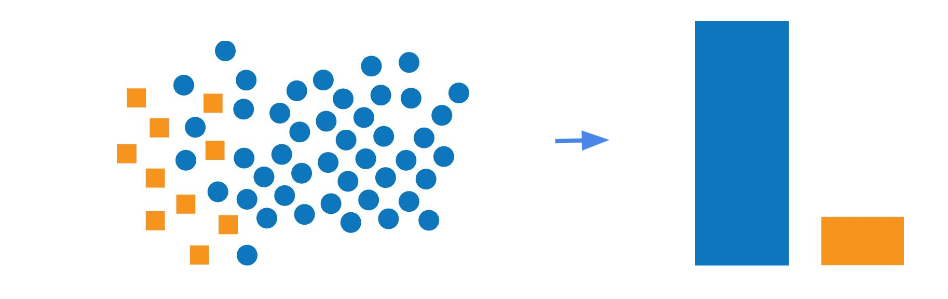

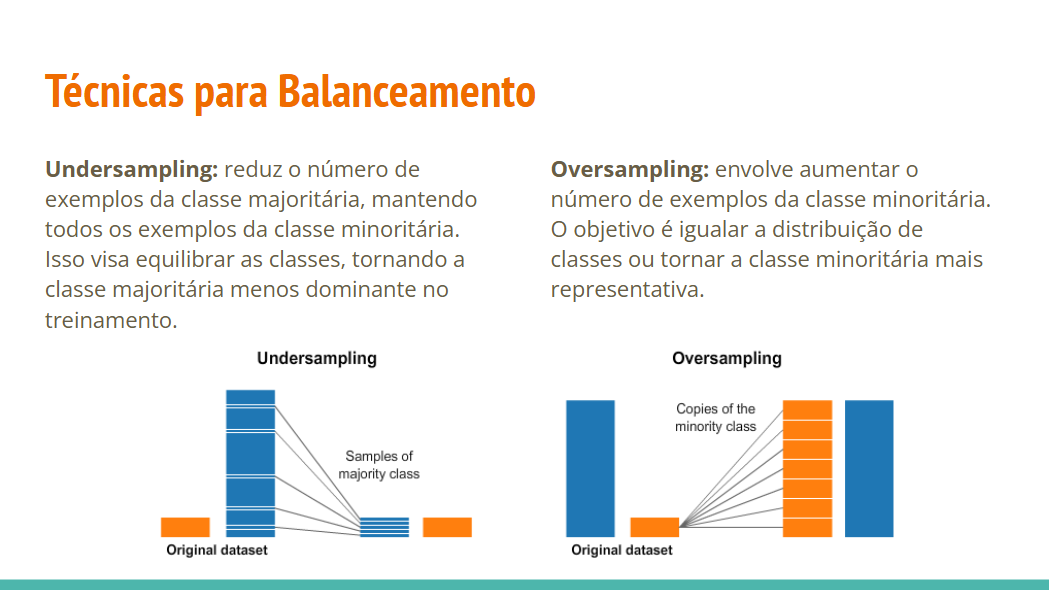

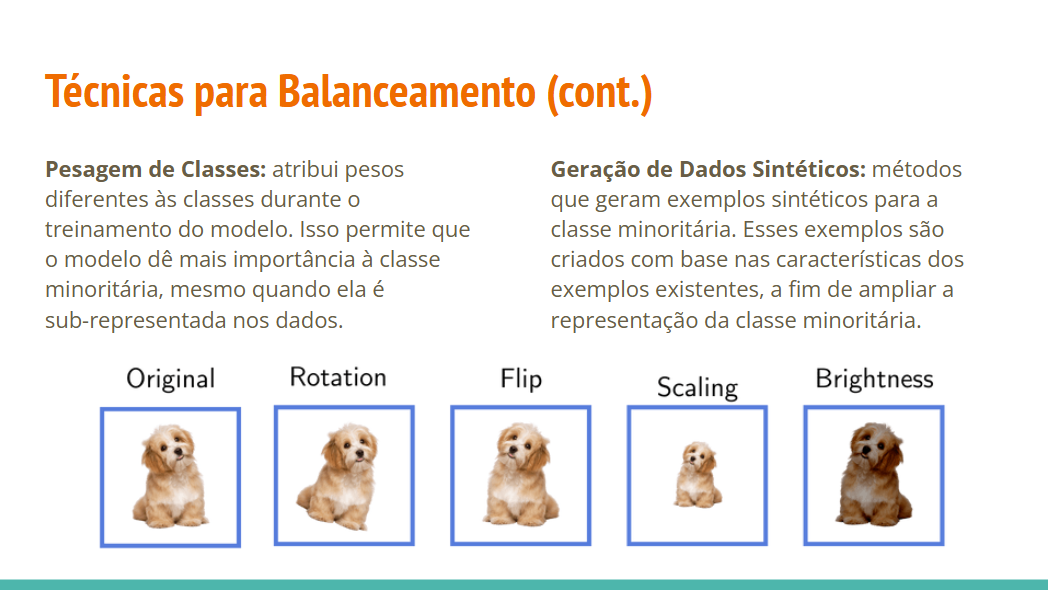

Vamos verificar se o nosso conjunto de dados √© desbalanceado em rela√ß√£o √† vari√°vel de interesse.

In [74]:
# Verificar balanceamento do dataset
print('Valor Absoluto')
print(df['stroke'].value_counts())
print('\n')

print('Valor Percentual')
print(df['stroke'].value_counts() / len(df) * 100)

Valor Absoluto
stroke
0    4861
1     249
Name: count, dtype: int64


Valor Percentual
stroke
0    95.127202
1     4.872798
Name: count, dtype: float64


Nessa aula, n√£o vamos usar nenhuma t√©cnica para garantir o balanceamento dos dados. Vamos apenas exigir que as classes estejam **estratificadas**; isto √©, que a propor√ß√£o das classes seja a mesma no conjunto treinamento e teste.

In [75]:
# Parti√ß√£o estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print('Dataset de treinamento:', X_train.shape)
print('Dataset de teste:', X_test.shape)

Dataset de treinamento: (4088, 17)
Dataset de teste: (1022, 17)


## Modelos

Nesta aula, veremos alguns modelos cl√°ssicos de classifica√ß√£o, como regress√£o log√≠stica, k-vizinhos pr√≥ximos, √°rvore de decis√£o e support vector machine.

### Regress√£o Log√≠stica e √Årvore de Decis√£o

Para compararmos os novos modelos com os modelos anteriores, vamos treinar uma regress√£o log√≠stica e uma √°rvore de decis√£o no nosso conjunto de dados.

No sklearn, esse processo consiste em **quatro** passos principais:

1.   Instanciar o modelo.
2.   Ajustar para os dados de treinamento.
3.   Fazer a predi√ß√£o para os dados de teste.
4.   Calcular as m√©tricas adequadas.



Vamos criar um dicion√°rio para armazenar os resultados dos classificadores.

In [76]:
class_metrics = {}

In [77]:
# Treinando o classificador Regress√£o Log√≠stica
clf_dt = LogisticRegression()
clf_dt.fit(X_train, y_train)

# Aplicando ao conjunto de teste
dt_pred = clf_dt.predict(X_test)

# Calculando m√©tricas
dt_acc = accuracy_score(y_test, dt_pred)
dt_f1 = f1_score(y_test, dt_pred)

# Armazenando resultados
class_metrics['RegLog'] = [dt_acc, dt_f1]

print(f'Regress√£o Log√≠stica. Acur√°cia: {dt_acc * 100:.4}, F1-score: {dt_f1 * 100:.4}')

Regress√£o Log√≠stica. Acur√°cia: 95.11, F1-score: 3.846


In [78]:
# Treinando o classificador k-NN
clf_lr = KNeighborsClassifier(n_neighbors=3)
clf_lr.fit(X_train, y_train)

# Aplicando ao conjunto de teste
lr_pred = clf_lr.predict(X_test)

# Calculando m√©tricas
lr_acc = accuracy_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)

# Armazenando resultados
class_metrics['kNN'] = [lr_acc, lr_f1]

print(f'k-Vizinhos Pr√≥ximos. Acur√°cia: {lr_acc * 100:.4}, F1-score: {lr_f1 * 100:.4}')

k-Vizinhos Pr√≥ximos. Acur√°cia: 94.62, F1-score: 9.836


Para comparar os resultados, podemos plotar um gr√°fico. Para isso, definimos uma fun√ß√£o que, quando chamada, exibe os resultados armazenados no dicion√°rio.

In [79]:
def plot_model_metrics(metrics_dict):
    models = list(metrics_dict.keys())
    accuracy = [val[0] for val in metrics_dict.values()]
    fscore = [val[1] for val in metrics_dict.values()]

    x = np.arange(len(models))
    width = 0.35

    plt.bar(x - width/2, accuracy, width, label='Accuracy')
    plt.bar(x + width/2, fscore, width, label='F-score')
    plt.xticks(x, models)
    plt.ylabel('Score')
    plt.title('Model Comparison')
    plt.legend()
    plt.show()

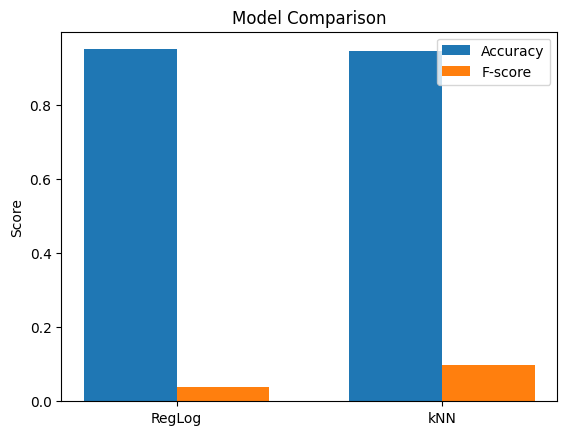

In [80]:
# Plotando os resultados
plot_model_metrics(class_metrics)

### √Årvore de Decis√£o

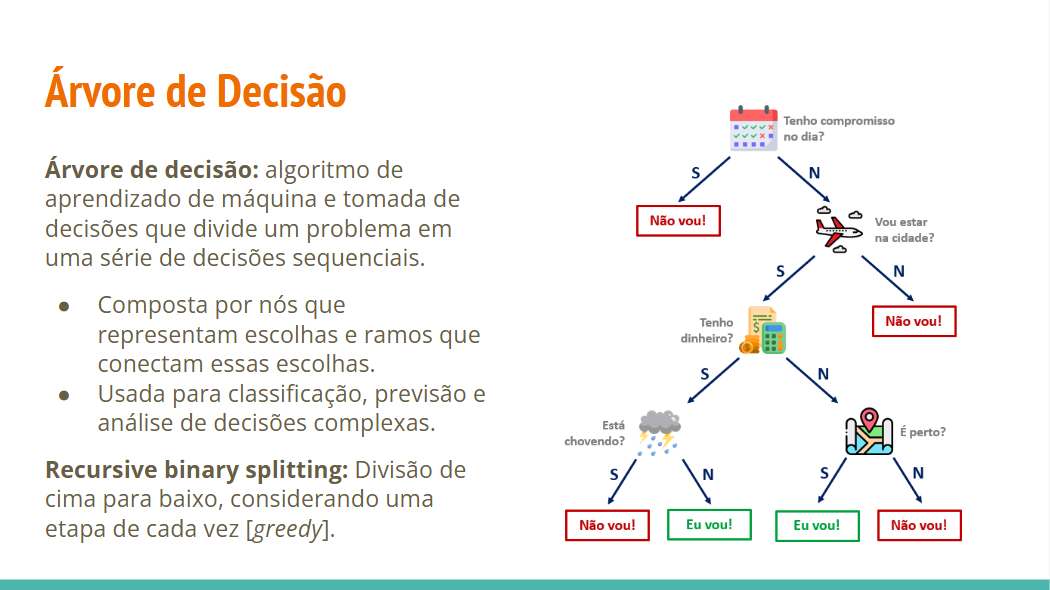

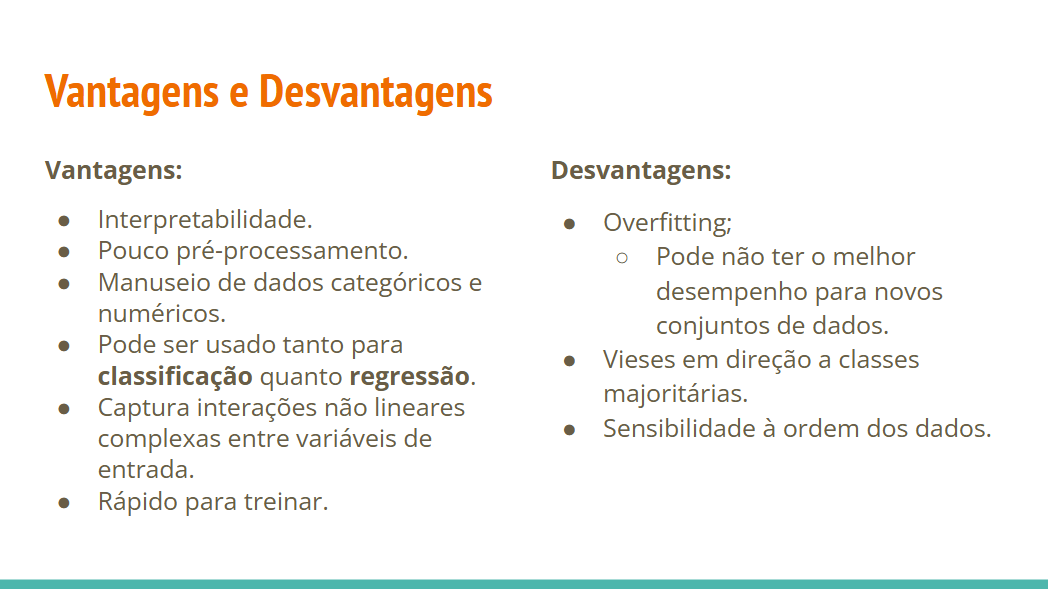

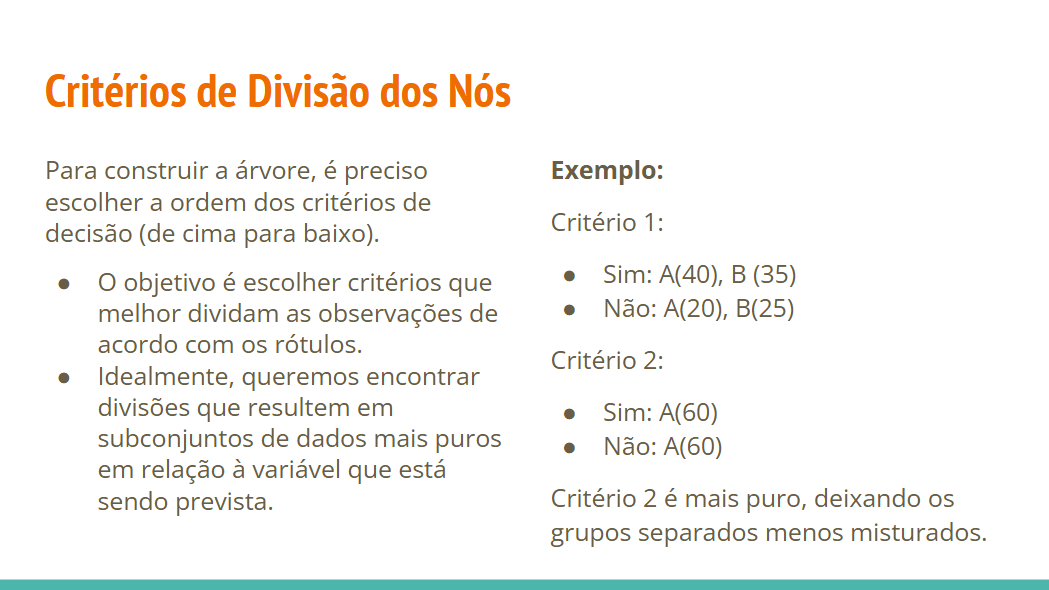

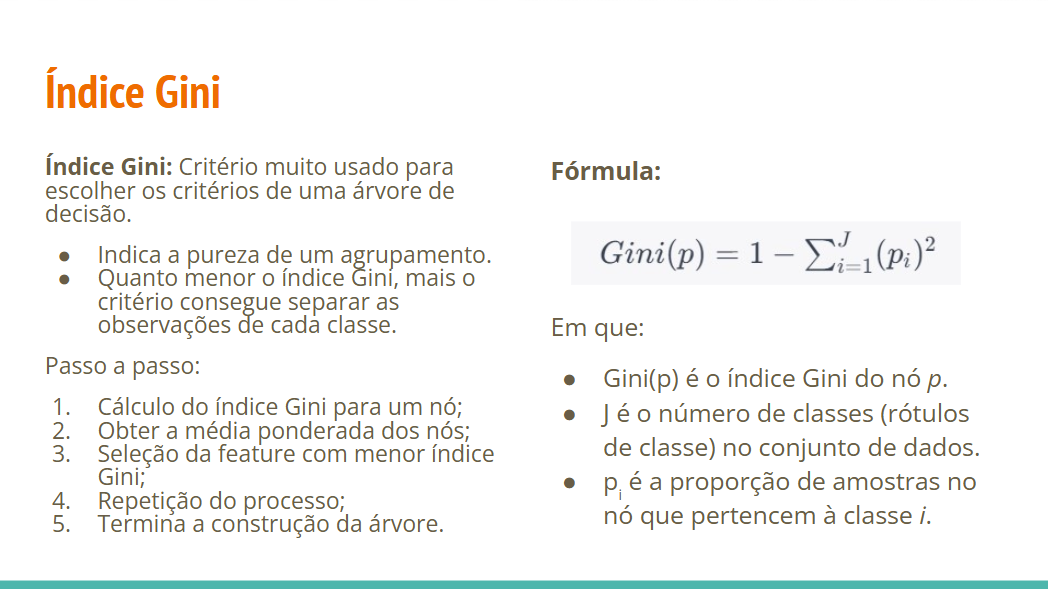

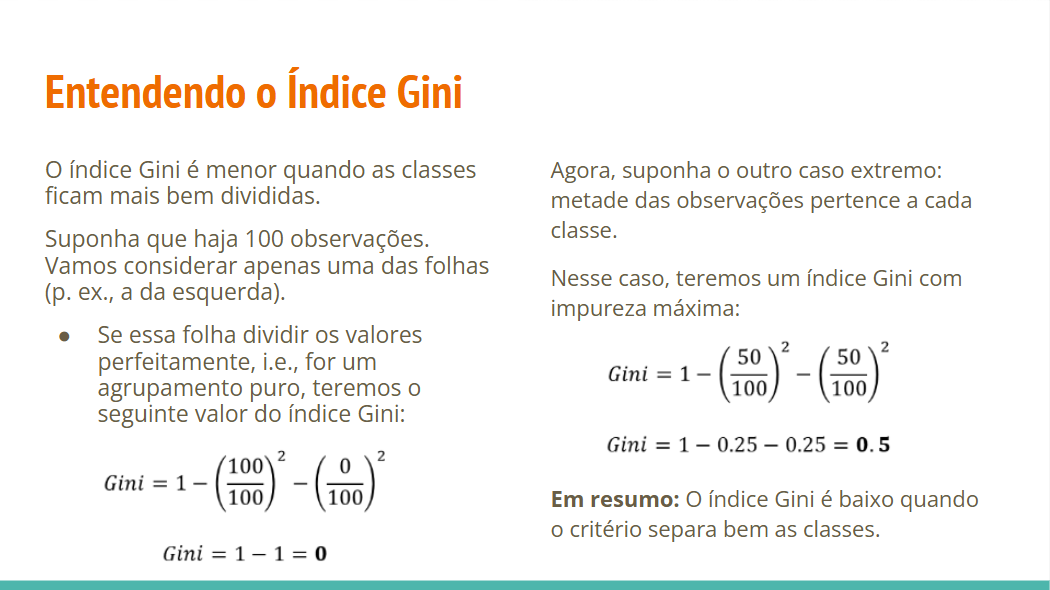

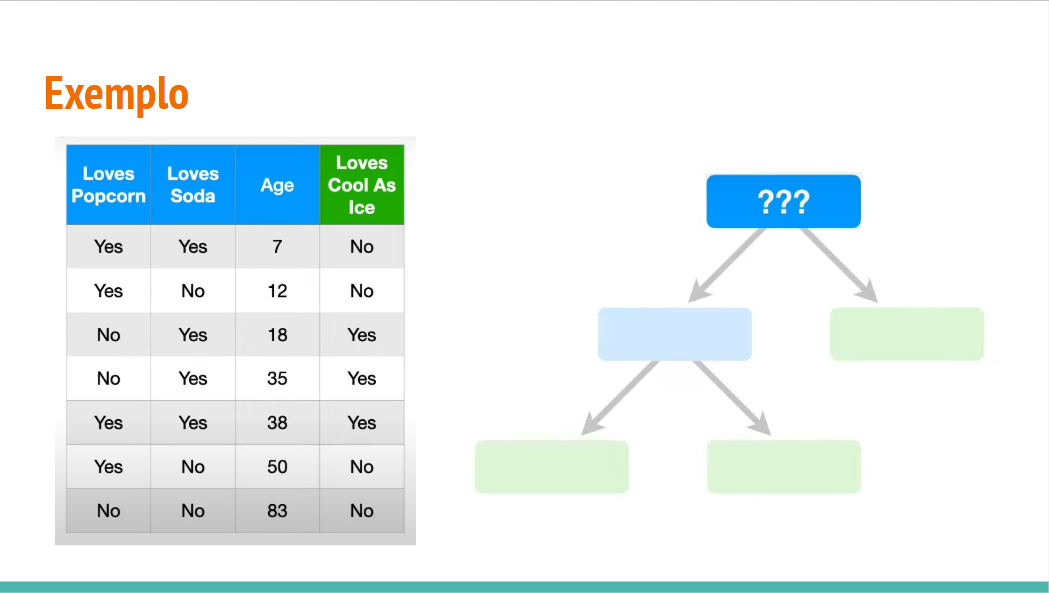

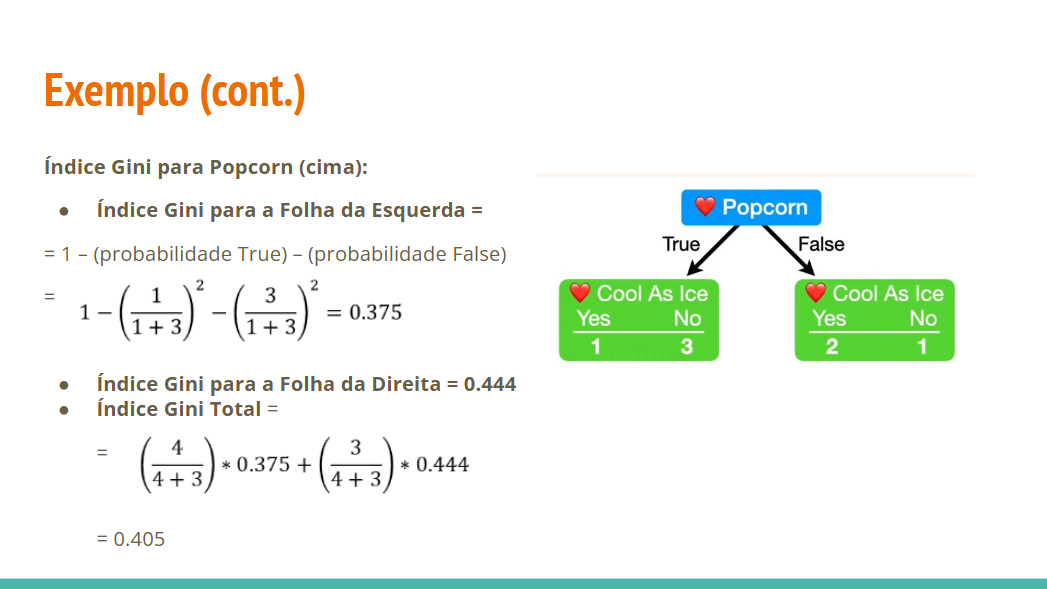

Vamos treinar nossa √°rvore de decis√£o.

In [81]:
# Cria o modelo
clf_tree = DecisionTreeClassifier()

# Ajusta os par√¢metros
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [82]:
# Aplica ao conjunto teste
tree_pred = clf_tree.predict(X_test)

# Calcula m√©tricas
tree_acc = accuracy_score(y_test, tree_pred)
tree_f1 = f1_score(y_test, tree_pred)

# Calcula m√©tricas de avalia√ß√£o
class_metrics['DecTree'] = [tree_acc, tree_f1]

print(f'√Årvore de Decis√£o. Acur√°cia: {tree_acc * 100:.4}, F1-score: {tree_f1 * 100:.4}')

√Årvore de Decis√£o. Acur√°cia: 91.98, F1-score: 19.61


Podemos plotar novamente os resultados comparando os modelos.

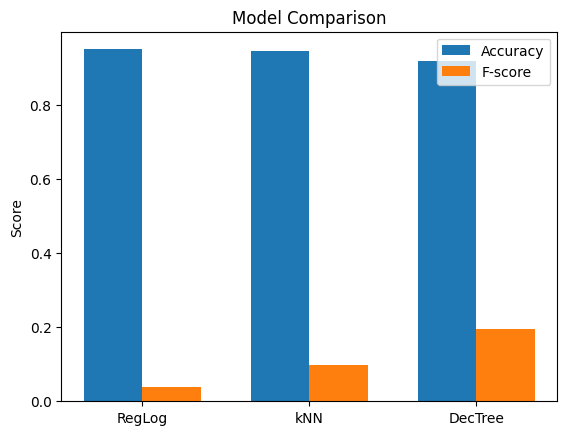

In [83]:
plot_model_metrics(class_metrics)

Uma das vantagens da √°rvore de decis√£o √© que ela estabelece uma sequ√™ncia de decis√µes para a classifica√ß√£o dos dados. Existem ferramentas que permitem visualizar essa estrutura.

In [84]:
# Selecionar as colunas de entrada

cols_in = list(df.columns)
cols_out = df['stroke']

cols_in.remove('stroke')

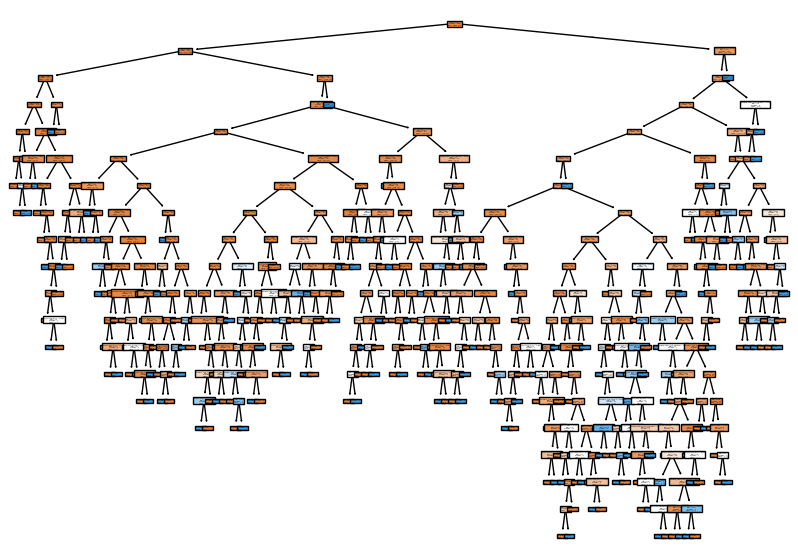

In [85]:
columns = df.columns

fig = plt.figure(figsize=(10,7))
_ = tree.plot_tree(clf_tree,
                   feature_names=cols_in,
                   filled=True)

### Floresta Aleat√≥ria

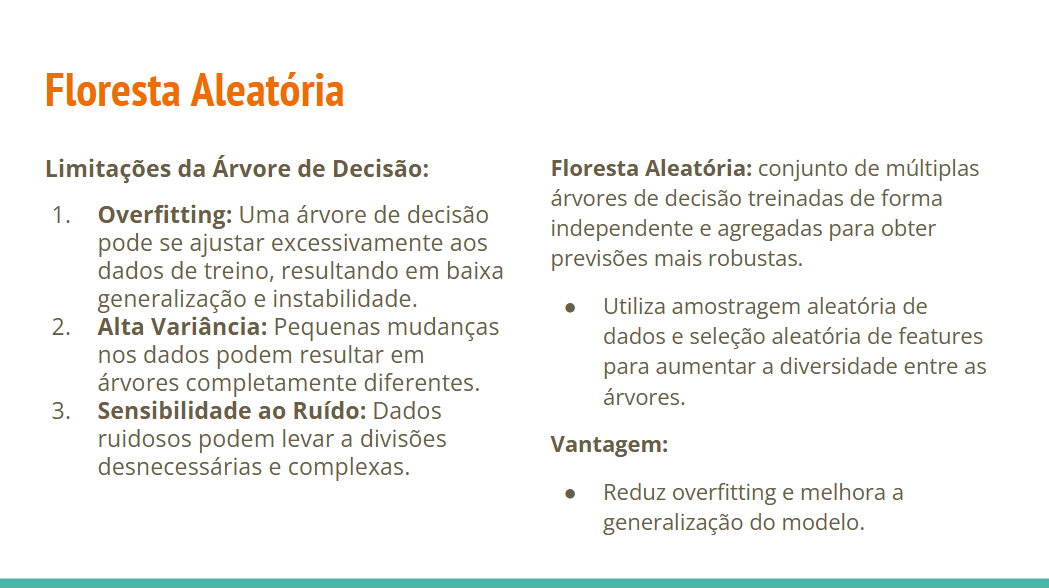

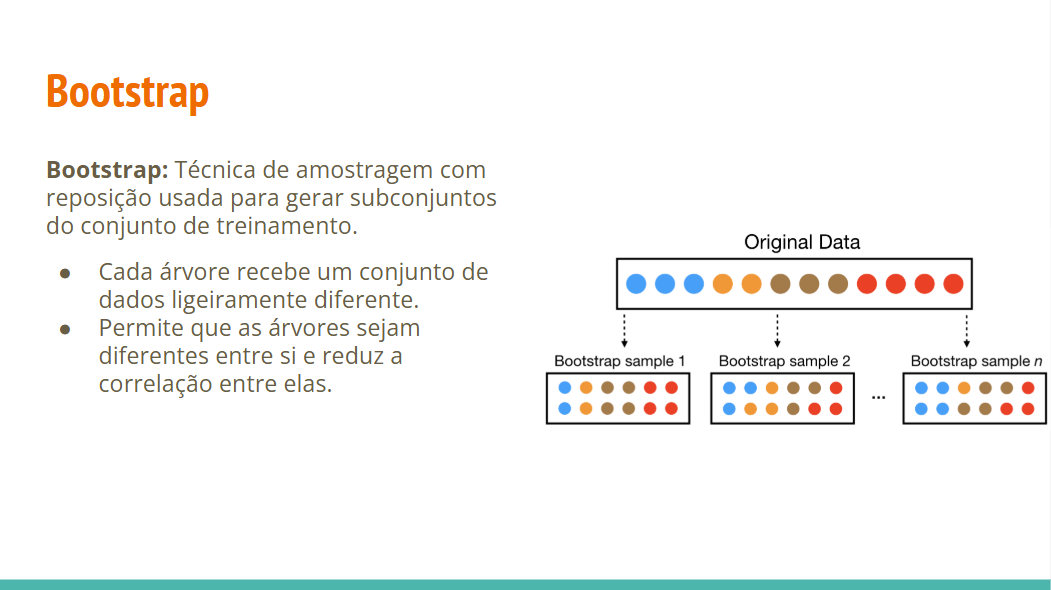

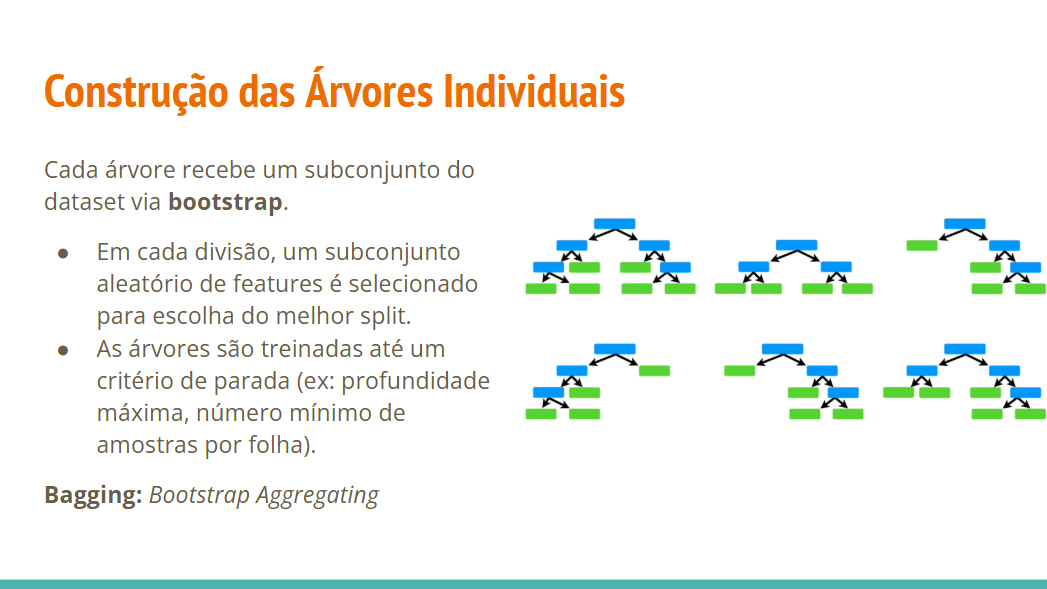

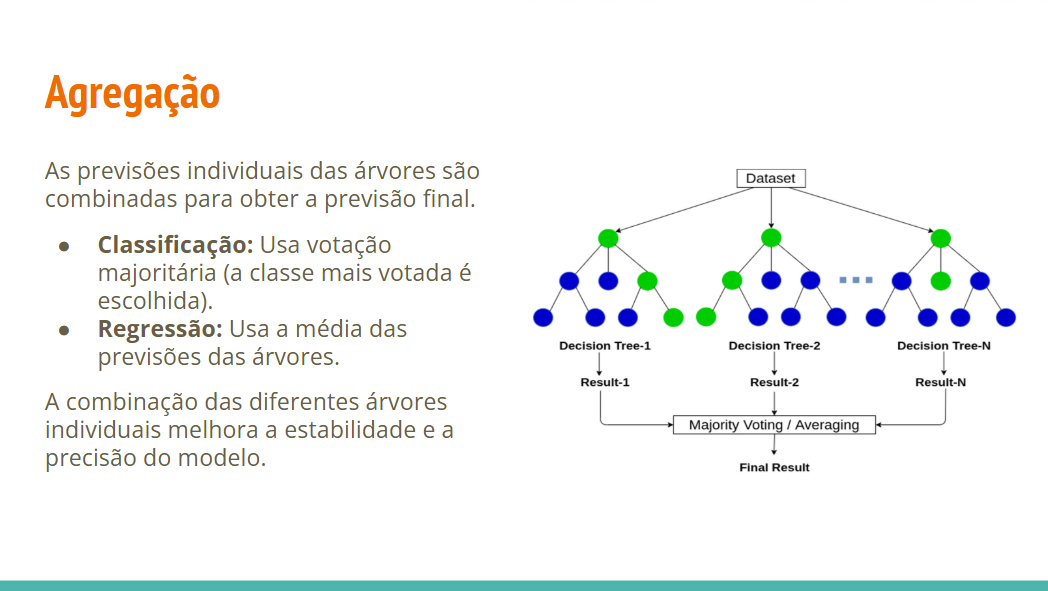

Vamos agora treinar uma floresta aleat√≥ria para o nosso conjunto de dados.

In [86]:
# Treinando o classificador Floresta Aleat√≥ria
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)

# Aplicando ao conjunto de teste
rf_pred = clf_rf.predict(X_test)

# Calculando m√©tricas
rf_acc = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)

# Armazenando resultados
class_metrics['RandFor'] = [rf_acc, rf_f1]

print(f'Floresta Aleat√≥ria. Acur√°cia: {rf_acc * 100:.4}, F1-score: {rf_f1 * 100:.4}')

Floresta Aleat√≥ria. Acur√°cia: 94.91, F1-score: 3.704


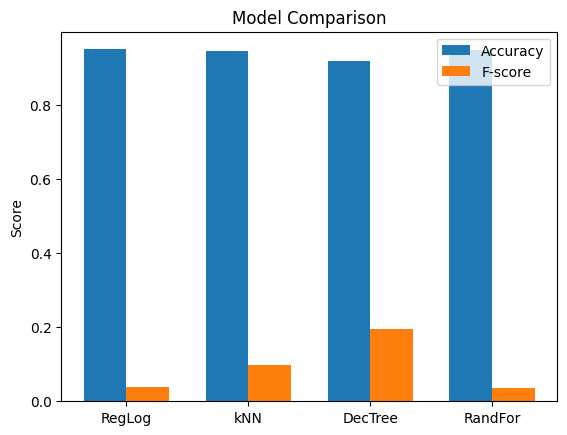

In [87]:
# Plotando os resultados
plot_model_metrics(class_metrics)

# **Atividade: Previs√£o de Doen√ßa Card√≠aca com Aprendizado de M√°quina**

## **Contexto**
As doen√ßas cardiovasculares s√£o a principal causa de morte no mundo, representando **31% de todas as mortes globais**. O reconhecimento precoce dos fatores de risco pode ajudar na preven√ß√£o e no tratamento adequado.

Neste estudo, voc√™ utilizar√° **dados cl√≠nicos de pacientes** para desenvolver um modelo de aprendizado de m√°quina capaz de prever se um paciente tem **doen√ßa card√≠aca** com base em suas caracter√≠sticas m√©dicas.

---

## **Objetivo da Tarefa**
Criar um **modelo de classifica√ß√£o** que receba as caracter√≠sticas cl√≠nicas do paciente e **preveja a presen√ßa de doen√ßa card√≠aca** (`HeartDisease`: **1** = Doen√ßa card√≠aca, **0** = Normal).

---

## **Descri√ß√£o dos Dados**
Cada paciente √© descrito por **11 atributos**, incluindo idade, tipo de dor no peito, colesterol, press√£o arterial, frequ√™ncia card√≠aca m√°xima, entre outros.

### **üìå Entrada (features)**
- `Age`: Idade do paciente (anos).  
- `Sex`: Sexo biol√≥gico (`M`: Masculino, `F`: Feminino).  
- `ChestPainType`: Tipo de dor no peito (`TA`, `ATA`, `NAP`, `ASY`).  
- `RestingBP`: Press√£o arterial em repouso (mm Hg).  
- `Cholesterol`: N√≠vel de colesterol s√©rico (mg/dl).  
- `FastingBS`: Glicose em jejum (>120 mg/dl = **1**, caso contr√°rio = **0**).  
- `RestingECG`: Resultados do eletrocardiograma (`Normal`, `ST`, `LVH`).  
- `MaxHR`: Frequ√™ncia card√≠aca m√°xima atingida.  
- `ExerciseAngina`: Angina induzida por exerc√≠cio (`Y` = Sim, `N` = N√£o).  
- `Oldpeak`: Depress√£o do segmento ST durante o exerc√≠cio.  
- `ST_Slope`: Inclina√ß√£o do segmento ST (`Up`, `Flat`, `Down`).  

### **üéØ Sa√≠da (target)**
- `HeartDisease`: **1** se o paciente tem doen√ßa card√≠aca, **0** caso contr√°rio.  

Link para baixar o dataset: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

---

## **Tarefa**
1. **Pr√©-processamento dos dados**  
   - Converter atributos categ√≥ricos em valores num√©ricos (ex.: `ChestPainType`, `RestingECG`).  
   - Normalizar ou padronizar vari√°veis num√©ricas se necess√°rio.  

2. **Dividir o dataset** em treino e teste para avalia√ß√£o do modelo.  

3. **Treinar modelos de classifica√ß√£o** para a tarefa.  

4. **Avaliar o desempenho** do modelo usando **acur√°cia** e **F1-score**.  

---

## **Pergunta Final**
‚û° **Qual modelo consegue prever com maior precis√£o a presen√ßa de doen√ßa card√≠aca?**  


In [88]:
df = pd.read_csv('heart.csv')

print(f'Dimensionalidade: {df.shape}')

df.head()

Dimensionalidade: (918, 12)


Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0

Vejamos se as classes est√£o balanceadas.

HeartDisease
1    0.553377
0    0.446623
Name: proportion, dtype: float64


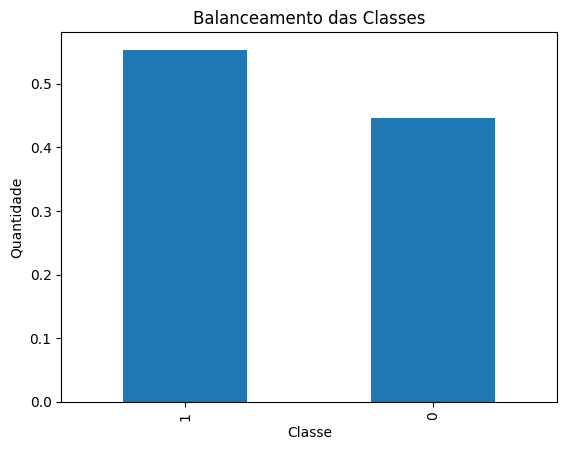

In [89]:
print(df['HeartDisease'].value_counts(normalize=True))

df['HeartDisease'].value_counts(normalize=True).plot(kind='bar')
plt.title('Balanceamento das Classes')
plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.show()

### Pr√©-Processamento

Convers√£o de vari√°veis categ√≥ricas.

In [90]:
df = pd.get_dummies(df, drop_first=True)

df.head()

Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease  \
0   40        140          289          0    172      0.0             0   
1   49        160          180          0    156      1.0             1   
2   37        130          283          0     98      0.0             0   
3   48        138          214          0    108      1.5             1   
4   54        150          195          0    122      0.0             0   

   Sex_M  ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  \
0   True               True              False             False   
1  False              False               True             False   
2   True               True              False             False   
3  False              False              False             False   
4   True              False               True             False   

   RestingECG_Normal  RestingECG_ST  ExerciseAngina_Y  ST_Slope_Flat  \
0               True          False             False          False   
1               True          False             False           True   
2              False           True             False          False   
3               True          False              True           True   
4               True          False             False          False   

   ST_Slope_Up  
0         True  
1        False  
2         True  
3        False  
4         True

Normaliza√ß√£o

In [91]:
y = df['HeartDisease']

# Elimina a coluna de sa√≠da
X = df.drop(columns=['HeartDisease'])

# Normaliza√ß√£o
scaler = StandardScaler()

scaler.fit(X)

X = scaler.transform(X)

print(X)

[[-1.4331398   0.41090889  0.82507026 ... -0.8235563  -1.00218103
   1.15067399]
 [-0.47848359  1.49175234 -0.17196105 ... -0.8235563   0.99782372
  -0.86905588]
 [-1.75135854 -0.12951283  0.7701878  ... -0.8235563  -1.00218103
   1.15067399]
 ...
 [ 0.37009972 -0.12951283 -0.62016778 ...  1.21424608  0.99782372
  -0.86905588]
 [ 0.37009972 -0.12951283  0.34027522 ... -0.8235563   0.99782372
  -0.86905588]
 [-1.64528563  0.30282455 -0.21769643 ... -0.8235563  -1.00218103
   1.15067399]]


Dividir entre treino e teste.

In [92]:
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Treinamento de Modelos

In [93]:
# Dicion√°rio com modelos
modelos = {
    '√Årvore de Decis√£o': DecisionTreeClassifier(),
    'Floresta Aleat√≥ria': RandomForestClassifier(),
    'Regress√£o Log√≠stica': LogisticRegression(),
    'KNN': KNeighborsClassifier(n_neighbors=2)
}

# Armazenar m√©tricas
resultados = {'Modelo': [], 'Acur√°cia': [], 'F1-score': []}

# Treinar e avaliar
for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    resultados['Modelo'].append(nome)
    resultados['Acur√°cia'].append(acc)
    resultados['F1-score'].append(f1)

In [94]:
# Print dos resultados
print("Resultados dos Modelos:\n")
for i in range(len(resultados['Modelo'])):
    nome = resultados['Modelo'][i]
    acc = resultados['Acur√°cia'][i]
    f1 = resultados['F1-score'][i]
    print(f"{nome:<20} | Acur√°cia: {acc:.4f} | F1-score: {f1:.4f}")

Resultados dos Modelos:

√Årvore de Decis√£o    | Acur√°cia: 0.7935 | F1-score: 0.8190
Floresta Aleat√≥ria   | Acur√°cia: 0.8913 | F1-score: 0.9038
Regress√£o Log√≠stica  | Acur√°cia: 0.8859 | F1-score: 0.9005
KNN                  | Acur√°cia: 0.8478 | F1-score: 0.8526


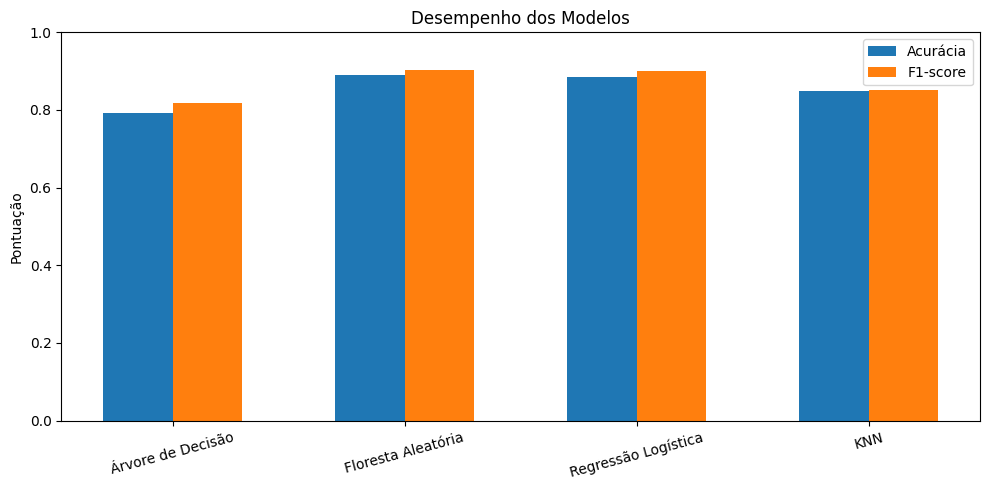

In [95]:
# Criar DataFrame com os resultados (caso ainda n√£o tenha)
resultados_df = pd.DataFrame(resultados)

# Dados
modelos = resultados_df['Modelo']
acuracias = resultados_df['Acur√°cia']
f1_scores = resultados_df['F1-score']
x = np.arange(len(modelos))

# Plot
plt.figure(figsize=(10, 5))
plt.bar(x - 0.15, acuracias, width=0.3, label='Acur√°cia')
plt.bar(x + 0.15, f1_scores, width=0.3, label='F1-score')

# Configura√ß√µes
plt.xticks(x, modelos, rotation=15)
plt.ylim(0, 1)
plt.ylabel('Pontua√ß√£o')
plt.title('Desempenho dos Modelos')
plt.legend()
plt.tight_layout()
plt.show()

Conclus√£o: O melhor modelo, em termos de F1-score, foi a **Regress√£o Log√≠stica** (0.9005). Os resultados, por√©m, foram bem pr√≥ximos aos modelos K-NN e Floresta Aleat√≥ria. O modelo com o pior desempenho foi a √Årvore de Decis√£o.